<a href="https://colab.research.google.com/github/carmenpelayo/Location-Recommendation-System-for-ICT-Businesses/blob/main/Datasets_TFG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Module Imports

import pandas as pd
from pandas import *
from numpy import array
# from sklearn.metrics.pairwise import cosine_similarity 
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

# H2020 Projects DB

In [ ]:
xlsx = pd.ExcelFile('Datasets/ICT_H2020.xlsx')
projects = pd.read_excel(xlsx, 'Proyectos')
areas = pd.read_excel(xlsx, 'Areas')

## Data quality validation 


Proof that Investment in ICT and GDP are correlated:


/Users/cpelayofernandez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


0.93024073408751


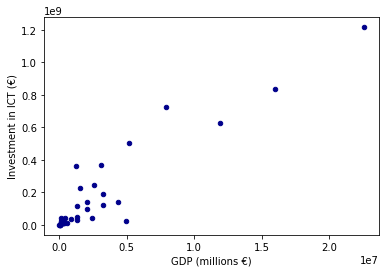

In [ ]:
# DESI index
df_gpd = pd.read_excel('Datasets/GPD_countries.xlsx', sheet_name = 'Resumen')
df_gpd = df_gpd[['country','gpd']] # Select relevant columns

# ICT Projects
df_p = projects[['Country Code', 'EU Contribution (€)']] # Select relevant columns
df_p.replace('-',0.0, inplace = True) # Fix non-zero values
df_countries = df_p.groupby('Country Code').sum().reset_index() # Group by country
df_countries.columns = ['country', 'grants'] # Change column names

# Merge dataframes
df = pd.merge(df_gpd, df_countries, how = 'inner', on = 'country') # Merge values
ax1 = df.plot.scatter(x='gpd',y='grants', c='DarkBlue') # Scatter Plot
ax1.set_xlabel("GDP (millions €)")
ax1.set_ylabel("Investment in ICT (€)")

# Correlation Coefficient
correl = df['gpd'].corr(df['grants']) # Correlation computation
print(correl) 

## Data Cleaning

In [ ]:
#Raw df
areas.head(5)

,Area,Topic,Descripción
0,AI,DT-ICT-12-2020,AI for the smart hospital of the future
1,AI,ICT-17-2014,Cracking the language barrier
2,AI,ICT-22-2014,Multimodal and Natural computer interaction
3,AI,ICT-26-2018-2020,Artificial Intelligence
4,AI,ICT-29-2018,A multilingual Next Generation Internet


### Cleaning db "areas"

In [ ]:
#PROBLEM 1: two different area names for communication: "Comunicación" and "communication"
#PROBLEM 2: some area names are in english and others in spanish
#PROBLEM 3: some column names are in english
#PROBLEM 4: change "Topic" to "Topic Code" (col 2 name) to match the same name as in "projects" df

for i in range(len(areas)):
    if areas["Area"].iloc[i] == "Comunicación":
        areas["Area"].iloc[i] = "Media & Communication"
    elif areas["Area"].iloc[i] == "communication":
        areas["Area"].iloc[i] = "Media & Communication"
    elif areas["Area"].iloc[i] == "Media":
        areas["Area"].iloc[i] = "Media & Communication"
    elif areas["Area"].iloc[i] == "Computación":
        areas["Area"].iloc[i] = "Computation"
    elif areas["Area"].iloc[i] == "ciberseguridad":
        areas["Area"].iloc[i] = "Cybersecurity"
    elif areas["Area"].iloc[i] == "Robot":
        areas["Area"].iloc[i] = "Robotics"
    elif areas["Area"].iloc[i] == "Otros":
        areas["Area"].iloc[i] = "Other"
    elif areas["Area"].iloc[i] == "Robot":
        areas["Area"].iloc[i] = "Robotics"
    elif areas["Area"].iloc[i] == "Innovación":
        areas["Area"].iloc[i] = "Innovation"
    elif areas["Area"].iloc[i] == "Big data":
        areas["Area"].iloc[i] = "Big Data"

#Clean df
areas = areas.rename(columns={"Topic": "Topic Code", "Descripción": "Description"})   

In [ ]:
#Technoligcal areas (or topics)
topics = areas.groupby(by = "Area", as_index=False).count()
topics = list(topics["Area"])

### Cleaning df "projects"

In [ ]:
list(projects.columns)

['Framework Programme',
 'Call ID',
 'Topic Code',
 'Topic Descr',
 'Project Nbr',
 'CORDIS link',
 'Project Acronym',
 'Project Title',
 'Partner Role',
 'Partner Type',
 'General PIC',
 'Legal Entity VAT',
 'Legal Name',
 'Legal Entity Type',
 'Legal Entity Type Descr',
 'City',
 'NUTS 3 Code',
 'NUTS 3 Name',
 'Country Code',
 'Country',
 'EU Contribution (€)',
 'H2020 Net EU Contribution',
 'H2020 Total Cost',
 'Signature Date',
 'Call Deadline  Date',
 'Thematic Priority Abbr',
 'Thematic Priority Descr',
 'SME Flag',
 'Project Start Date',
 'Project End Date',
 'Pillar Abbr',
 'Pillar Descr',
 'Simplified Type of Action',
 'Focus Area']

Meaningless columns -> observed with groupby method that all rows have the same value for those columns (they do not provide any useful information for the study).

- Pillar Descr
- General PIC
- Thematic Priority Abbr
- Thematic Priority Descr
- Pillar Abbr
- Pillar Descr
- Focus Area -> most rows do not have a value for this column

Therefore, we can eliminate them from the database.

In [ ]:
meaningless_cols = ['Pillar Descr', 'General PIC', 'Thematic Priority Abbr', 'Thematic Priority Descr', 'Pillar Abbr', 'Pillar Descr', 'Simplified Type of Action', 'Focus Area']
projects.drop(meaningless_cols, axis = 1, inplace = True)

In [ ]:
#Getting NUTS2 codes
projects['NUTS 2 Code'] = projects['NUTS 3 Code'].str[:4]

In [ ]:
#Deleting the project with unspecified region from "projects" df
idx = projects[projects["NUTS 2 Code"] == "-"].index.tolist()[0]
projects = projects.drop(idx)

### Merge of "projects" and "areas"

In [ ]:
projects = pd.merge(projects, areas, on = 'Topic Code') # Se añade 'N_Countries' según el acrónimo
projects.head(5) #final DB

,Framework Programme,Call ID,Topic Code,Topic Descr,Project Nbr,CORDIS link,Project Acronym,Project Title,Partner Role,Partner Type,...,H2020 Net EU Contribution,H2020 Total Cost,Signature Date,Call Deadline Date,SME Flag,Project Start Date,Project End Date,NUTS 2 Code,Area,Description
0,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,COORDINATOR,BENEFICIARY,...,335222.0,897410.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,DE11,Other,ECSEL Key Applications and Essential Technolog...
1,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,126750.0,390000.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,FI1B,Other,ECSEL Key Applications and Essential Technolog...
2,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,82523.0,336100.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,DE71,Other,ECSEL Key Applications and Essential Technolog...
3,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,61165.0,188000.0,16/06/2015,17/09/2014,Yes,01/06/2015,31/05/2018,FI1D,Other,ECSEL Key Applications and Essential Technolog...
4,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,201013.0,618500.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,ES51,Other,ECSEL Key Applications and Essential Technolog...


#### Further cleaning? -> Understanding the data

Some tech area names ("Other", "SME" and "Innovation") do not communicate the market area of their products/services. For this reason, it needs to be checked whether they are significant enough in the database, otherwise they could be dropped. After printing the length of these rows, it can be seen that they are few "SME" and "Innovation" projects in comparison to the total projects in the DB (576  for "SME" and 784 for "Innovation", out of 18411 projects in the DB). Therefore, we can drop those projects from the database.

In [ ]:
idx2 = projects[projects["Area"] == "Other"].index.to_list()
idx3 = projects[projects["Area"] == "SME"].index.to_list()
idx4 = projects[projects["Area"] == "Innovation"].index.to_list()
print(len(idx2), len(idx3), len(idx4))

idx3.extend(idx4)
projects = projects.drop(idx3, axis = 0)
projects.head()

6740 576 784


,Framework Programme,Call ID,Topic Code,Topic Descr,Project Nbr,CORDIS link,Project Acronym,Project Title,Partner Role,Partner Type,...,H2020 Net EU Contribution,H2020 Total Cost,Signature Date,Call Deadline Date,SME Flag,Project Start Date,Project End Date,NUTS 2 Code,Area,Description
0,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,COORDINATOR,BENEFICIARY,...,335222.0,897410.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,DE11,Other,ECSEL Key Applications and Essential Technolog...
1,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,126750.0,390000.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,FI1B,Other,ECSEL Key Applications and Essential Technolog...
2,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,82523.0,336100.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,DE71,Other,ECSEL Key Applications and Essential Technolog...
3,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,61165.0,188000.0,16/06/2015,17/09/2014,Yes,01/06/2015,31/05/2018,FI1D,Other,ECSEL Key Applications and Essential Technolog...
4,H2020,ECSEL-2014-1,ECSEL-01-2014,ECSEL Key Applications and Essential Technolog...,661933,http://cordis.europa.eu/project/id/661933,RobustSENSE,Robust and Reliable Environment Sensing and Si...,PARTICIPANT,BENEFICIARY,...,201013.0,618500.0,16/06/2015,17/09/2014,No,01/06/2015,31/05/2018,ES51,Other,ECSEL Key Applications and Essential Technolog...


In [ ]:
#Number of projects and areas
length_projects = len(projects)
length_areas = len(areas)
print(length_projects, length_areas)

17051 225


In [ ]:
#Number of regions per country considered in the study
count_reg_count = projects.groupby(["Country Code", "NUTS 2 Code"], as_index=False).count()
countries_count = count_reg_count.groupby("Country Code", as_index=False).count()
n_reg = {countries_count["Country Code"].iloc[i]:countries_count["NUTS 2 Code"].iloc[i] for i in range(len(countries_count))}

## Data Analysis

### DIMENSION 1: Tech Areas

In [ ]:
#Total projects per TECH area
tech_areas = projects.groupby(by = "Area").count().reset_index() #counts the number of times each market tech area appears in the dataframe
total_per_area = {}
for i in range(len(tech_areas)):
    total_per_area[tech_areas["Area"].iloc[i]] = tech_areas["Framework Programme"].iloc[i]
total_per_area

{'AI': 750,
 'Big Data': 1404,
 'Computation': 1099,
 'Cybersecurity': 652,
 'Internet': 730,
 'IoT': 1178,
 'Media & Communication': 2725,
 'Other': 6740,
 'Robotics': 1249,
 'Software': 524}

In [ ]:
#List of regions
regions = list(projects.groupby(by = "NUTS 2 Code").count().reset_index()["NUTS 2 Code"])

#### Degree of specialization in each area for a specific region
The function _specialization()_ Returns the percentage of projects in each area with respect to the total of projects in that specific area among all the regions in Europe.
- Keys = tech area
- Values = number of projects in the region / total projects in H2020 (in an specific area)

In [ ]:
def specialization(region):
    proj_per_region = projects[projects["NUTS 2 Code"] == region]
    proj_per_area = proj_per_region.groupby(by = "Area").count().reset_index()
    prop_areas = {}
    for i in range(len(proj_per_area)):
        area = proj_per_area["Area"].iloc[i]
        prop_areas[area] = proj_per_area["Framework Programme"].iloc[i]/total_per_area[area]
    return prop_areas #dict with keys=areas and vals=percentage of projects in that area in the region

Now the matrix with the values of specialization in each tech area for all regions is created.

In [ ]:
market = pd.DataFrame()
market["ES30"] = specialization("ES30") #region with projects in all 14 areas
for region in regions:
    areas_series = pd.Series(specialization(region))
    market[region] = areas_series
market = market[regions] #sorting columns in ascending alphabetical order

### DIMENSION 2: Company size (SME or big enterprise)

#### Number of Small/Medium Enterprises (SMEs) per region

It is important to determine whether an institution is a SME because that indicates that the organization is in the initial phase, when it needs capital to start up operations and grow.

In [ ]:
smes_per_region = {}
for i in range(length_projects):
    if projects["SME Flag"].iloc[i] == "Yes":
        if projects["NUTS 2 Code"].iloc[i] not in smes_per_region:
            smes_per_region[projects["NUTS 2 Code"].iloc[i]] = 1
        else:
            smes_per_region[projects["NUTS 2 Code"].iloc[i]] += 1
    if projects["NUTS 2 Code"].iloc[i] not in smes_per_region:
        smes_per_region[projects["NUTS 2 Code"].iloc[i]] = 0

#Sorting in alphabetical order
smes_per_region = {regions[i]:smes_per_region[regions[i]] for i in range(len(regions))}

#### Number of non-SMEs (large enterprises) per region
Consolidated company -> The organization is mature, needs capital to grow and innovate.

In [ ]:
les_per_region = {}
for region in smes_per_region:
    les_per_region[region] = 1 - smes_per_region[region]

### DIMENSION 3: Technological Maturity
Proportion of deep tech/development/integration projects in each region. Considering data on "Entity Type", it will be assumed that:
- Higher or secondary education -> deep tech
- Others -> not specified, will not taken into consideration in the computation
- Private for profit (excl. education) -> integration
- Public body (excl. research and education) -> will not taken into consideration in the computation
- Research organisations -> development

In [ ]:
entity_types = set(projects["Legal Entity Type Descr"])
entities = [i for i in entity_types]

#Excluding projects that have "Others" value in column "Legal Entity Type Descr"
non_others_idx = list(projects[projects["Legal Entity Type Descr"] == "Others"].index)
non_others_projects = projects.drop(non_others_idx)

#Grouping and merging 
non_others_grouped = non_others_projects.groupby(["NUTS 2 Code", "Legal Entity Type Descr"], as_index = False).count()
non_others_totalprojects = non_others_grouped.groupby("NUTS 2 Code", as_index = False).sum()
non_others_merged = pd.merge(non_others_grouped, non_others_totalprojects, on = "NUTS 2 Code")

def tech_level_proportion(entity_type):
    classification = {}
    for i in range(len(non_others_merged)):
        if non_others_merged["Legal Entity Type Descr"].iloc[i] == entity_type:
            region = non_others_merged["NUTS 2 Code"].iloc[i]
            classification[region] = non_others_merged["Framework Programme_x"].iloc[i] / non_others_merged["Framework Programme_y"].iloc[i]
    
    #Filling with 0's the regions that do not have any universities
        for r in regions:
            if r not in classification:
                classification[r] = 0

    #Sorting in alphabetical order
    classification = {regions[i]:classification[regions[i]] for i in range(len(regions))}

    return classification

#Deep-tech proportion per region
deeptech_per_region = tech_level_proportion("Higher or secondary education")

#Development proportion per region
development_per_region = tech_level_proportion("Public body (excl. research and education)")

#Integration proportion per region
integration_per_region = tech_level_proportion("Private for profit (excl. education)")

### DIMENSION 4: Capital

#### Euro amount of capital grants received by each European region in H2020 projects

In [ ]:
grants = {}
for i in range(len(projects)):
    reg = projects["NUTS 2 Code"].iloc[i]
    inv = projects["H2020 Net EU Contribution"].iloc[i]
    if reg not in grants:
        grants[reg] = inv
    else:
        grants[reg] += inv
        
#Sorting in alphabetical order
grants_per_region = {regions[i]:grants[regions[i]] for i in range(len(regions))}

### DIMENSION 5: Human Resources

#### Number of universities that have participated in H2020 projects in each region

In [ ]:
universities = {}
for i in range(length_projects):
    if projects["Legal Entity Type Descr"].iloc[i] == "Higher or secondary education":
        if projects["NUTS 2 Code"].iloc[i] not in universities:
            universities[projects["NUTS 2 Code"].iloc[i]] = 1
        else:
            universities[projects["NUTS 2 Code"].iloc[i]] += 1

#Filling with 0's the regions that do not have any universities
for r in regions:
    if r not in universities:
        universities[r] = 0

#Sorting in alphabetical order
unis_per_region = {regions[i]:universities[regions[i]] for i in range(len(regions))}

### DIMENSION 6: Innovative Ecosystem

#### Networking capacity of each region

In [ ]:
#Each institution's networking capacity -> Number of companies/unis/tech centers each institution is collaborating with.
collabs = {}
acronyms = projects["Project Acronym"]
for i in range(len(projects)):
    project = acronyms.iloc[i]
    institution = projects["Legal Name"].iloc[i]
    if institution not in collabs:
        collabs[institution] = len(projects[acronyms == project]) - 1
    else:
        collabs[institution] += len(projects[acronyms == project]) - 1     

#Total networking capacity of a region
networking = {}
for ins in collabs:
    reg = list(projects[projects["Legal Name"] == ins]["NUTS 2 Code"])[0]
    if reg not in networking:
        networking[reg] = collabs[ins]
    else:
        networking[reg] += collabs[ins]

#Sorting in alphabetical order
networking_per_region = {regions[i]:networking[regions[i]] for i in range(len(regions))}

# DIGITALIZATION DB

In [ ]:
digitalization = pd.read_csv("Datasets/Subfactor score table.csv")
digitalization.head(5)

,Country,4G coverage,Fiber coverage,Internet BW per user,5G commercial networks,# of IXPs,# & maturity of 5G pilots,Time to get electricity,4G launch year,5G spectrum auction plans,...,VC availability,Tertiary (%),Skillset of univrsity graduates,Extent of staff training,Availability of scientists & engineers,e-Gov services,Competition in network services,GDP per capita,ICTs & business model creation,Internet users (% of population)
0,Finland,89.5,37.5,62.05,100.0,10.11,30.15,86.55,90.91,66.67,...,68.81,62.76,78.09,75.25,83.84,96.5,76.29,86.24,85.00,88.89
1,Switzerland,89.6,30.3,61.50,100.0,30.32,23.60,87.54,72.73,66.67,...,56.00,42.38,83.56,78.97,68.76,84.7,68.46,88.82,85.00,89.81
2,Germany,76.9,8.5,55.92,100.0,80.85,64.24,91.15,90.91,66.67,...,63.42,49.99,70.84,65.26,69.24,93.1,73.07,87.12,78.33,89.74
3,Denmark,88.6,64.4,62.59,25.0,12.63,10.49,87.87,90.91,33.33,...,46.50,57.37,75.01,71.17,56.60,100.0,62.60,87.17,75.00,97.64
4,Sweden,91.1,72.2,58.91,25.0,45.48,7.87,83.27,100.00,50.00,...,56.36,47.67,74.92,70.73,64.03,94.4,72.07,87.28,81.67,92.14


In [ ]:
# Columns in Digitalization DB
list(digitalization.columns)

['Country',
 '4G coverage',
 'Fiber coverage',
 'Internet BW per user',
 '5G commercial networks',
 '# of IXPs',
 '# & maturity of 5G pilots',
 'Time to get electricity',
 '4G launch year',
 '5G spectrum auction plans',
 'Govt ensuring policy stability',
 "Legal fwk's adaptability to digital BMs",
 'Efficiency in settling disputes',
 'Efficiency in challenging regulations',
 'Burden of govt regulation',
 'Public sector corruption',
 '# of days to start a business',
 'Companies with disruptive ideas',
 'Growth of innovative companies',
 'Researchers in R&D',
 'R&D expenditure (% of GDP)',
 'University-industry collaboration',
 'FDI & technology transfer',
 'VC availability',
 'Tertiary (%)',
 'Skillset of univrsity graduates',
 'Extent of staff training',
 'Availability of scientists & engineers',
 'e-Gov services',
 'Competition in network services',
 'GDP per capita',
 'ICTs & business model creation',
 'Internet users (% of population)']

With all this information, we can get very valuable insights on the digital capacity of each country. 

In [ ]:
#Defining a general function to convert national values into a dict of regional values
def nat_to_reg(nat_dimension):
    regional = {}
    for i in range(len(projects)):
        country = projects["Country"].iloc[i]
        reg = projects["NUTS 2 Code"].iloc[i]
        if reg not in regional:
            num = list(nat_dimension[nat_dimension["Country"] == country]["Overall"])
            if len(num) != 0:
                regional[reg] = num[0]/100
            else:
                regional[reg] = 0     
    #Sort per region names
    regional = {regions[i]:regional[regions[i]] for i in range(len(regions))}
    return regional

### DIMENSION 4.2: Capital

In [ ]:
more_investment = digitalization.loc[:, ['Country',
                                         'FDI & technology transfer',
                                         'R&D expenditure (% of GDP)',
                                         'VC availability']]
more_investment["Overall"] = list(more_investment.mean(axis = 1))
more_investment_per_region = nat_to_reg(more_investment)

### DIMENSION 5.2: Human Resources

In [ ]:
hhrr = digitalization.loc[:, ['Country',
                             'Researchers in R&D',
                             'University-industry collaboration',
                             'Skillset of univrsity graduates',
                             'Extent of staff training',
                             'Availability of scientists & engineers']]
hhrr["Overall"] = list(hhrr.mean(axis = 1))
hhrr_per_region = nat_to_reg(hhrr)

### DIMENSION 7: Government
#### Legal easiness to operate an ICT business

In [ ]:
legal = digitalization.loc[:, ['Country',
           'Govt ensuring policy stability', 
          "Legal fwk's adaptability to digital BMs",
          'Efficiency in settling disputes',
          'Efficiency in challenging regulations',
          'Burden of govt regulation',
          '# of days to start a business',
          'e-Gov services']]
legal["Overall"] = list(legal.mean(axis = 1))
legal_per_region = nat_to_reg(legal)

### DIMENSION 8: Tech Infrastructure

In [ ]:
infrastructure = digitalization.loc[:, ['Country',
                                       '4G coverage',
                                        'Fiber coverage',
                                        'Internet BW per user',
                                        '5G commercial networks',
                                        '# of IXPs',
                                        '# & maturity of 5G pilots',
                                        'Time to get electricity',
                                        '4G launch year',
                                        '5G spectrum auction plans']]
infrastructure["Overall"] = list(infrastructure.mean(axis = 1))
infrastructure_per_region = nat_to_reg(infrastructure)

# DIGITAL INNOVATION HUBS DB

In [ ]:
import numbers_parser
from numbers_parser import Document

doc4 = Document("Datasets/digital-innovation-hubs.numbers")
sheets4 = doc4.sheets()
tables4 = sheets4[0].tables()
rows4 = tables4[0].rows()
data4 = tables4[0].rows(values_only = True)
df4 = pd.DataFrame(data4)
headers4 = list(df4.iloc[0])
df4 = df4.iloc[1:]
df4.columns = headers4
df4.head(5)

,DIH Name,Location,City,Country,Website,NUTS2 Code,NUTS2 Name
1,Aachen DIH Center for Robotics in Healthcare,Pauwelsstraße 30,Aachen,Germany,http://www.robotics.ukaachen.de/,DEA2,Köln
2,Aalen University / Transfer Platform Industry 4.0,"Beethovenstraße, 1",Aalen,Germany,http://www.hs-aalen.de/,DE11,Stuttgart
3,"Aarhus University Centre for Digitalisation, B...",Finlandsgade 22,Aarhus,Denmark,http://www.digit.au.dk,DK04,Midtjylland
4,Accelerating Photonics innovation for SME’s (A...,"Brussels Photonics B-PHOT, Vrije Universiteit ...",Brussel,Belgium,http://www.actphast.eu,BE10,Région de Bruxelles-Capitale / Brussels Hoofds...
5,ADAPT Centre,"O'Reilly Building, Trinity College Dublin",Dublin,Ireland,https://www.adaptcentre.ie/,IE02,Southern and Eastern (NUTS 2013)


### DIMENSION 4.3: Innovative Ecosystem
#### Number of innovation hubs per region

In [ ]:
hubs = df4.groupby("NUTS2 Code ", as_index = False).count()
hubs_regs = list(hubs["NUTS2 Code "])
hubs_quant = list(hubs["DIH Name"])
hubs_per_region = {hubs_regs[i]: hubs_quant[i] for i in range(len(hubs))}

#Adding 0s to EU regions that do not have any tech hub 
for r in regions: 
    if r not in hubs_per_region:
        hubs_per_region[r] = 0

#Sorting list in alphabetical order
hubs_per_region = {regions[i]:hubs_per_region[regions[i]] for i in range(len(regions))}

# UNICORNS DB

In [ ]:
unicorns = pd.read_excel('Datasets/unicorns.xlsx')
unicorns.columns = unicorns.iloc[0]
unicorns = unicorns[1:]
unicorns.head(5)

,Company,Valuation,Date Joined,Country,City,Industry,Select Investors
1,1047 Games,$1.5,9/14/2021,United States,Zephyr Cove,Internet software & services,"VGames, Lakestar, Galaxy Interactive"
2,1KMXC,$1,8/30/2021,China,Hangzhou,Hardware,"Goldman Sachs Asset Management, SDP Investment..."
3,1Password,$6.8,7/8/2021,Canada,Toronto,Cybersecurity,"Slack Fund, Accel, Skip Capital"
4,4Paradigm,$2,12/19/2018,China,Beijing,Artificial intelligence,"Sequoia Capital China, China Construction Bank..."
5,56PINGTAI,$1.08,1/25/2021,China,Shanghai,"Supply chain, logistics, & delivery","QF Capital, QC Capital, Unicom Innovation Vent..."


## Data Quality Verification
Checking whether  the city or country as the location should be considered when assigning the number of the unicorns to a region. 
- Considering cities

In [ ]:
# Transforming all city names in unicorns DB to uppercase
unic_cities = list(unicorns["City"])
unic_cities = [x for x in unic_cities if pd.isnull(x) == False]
unic_cities = [u.upper() for u in unic_cities]
unic_cities

#List of cities in projects DB
eu_cities = list(projects.groupby("City", as_index = False).count()["City"])
eu_cities

yes = 0
no = 0
for c in unic_cities:
    if c not in eu_cities:
        no += 1
    else:
        yes += 1
print(yes, no)

150 933


- Considering countries

In [ ]:
unic_countries = list(unicorns["Country"])
unic_countries = [x for x in unic_countries if pd.isnull(x) == False]
eu_countries = list(projects.groupby("Country", as_index = False).count()["Country"])

yes = 0
no = 0
for c in unic_countries:
    if c not in eu_countries:
        no += 1
    else:
        yes += 1
print(yes, no)

147 953


Data on city names (istead of regions) will be used, since more of their values are matched with those cities in the master dataframe of vectors, apart from giving a more detailed level of information.
#### Function to obtain the values per region of any parameter

In [ ]:
#General function for unicorns DB
def unicorns_search(vals_per_city, parameter):
    param_per_region = {}
    for i in range(len(vals_per_city)):
        city = vals_per_city["City"].iloc[i].upper()
        if city in eu_cities:
            idx = eu_cities.index(city)
            region = projects[projects["City"] == eu_cities[idx]]["NUTS 2 Code"].iloc[0]
            param_val = vals_per_city[parameter].iloc[i]
            param_per_region[region] = param_val

    #adding 0s to EU regions that do not have any unicorn
    for r in regions: 
        if r not in param_per_region:
            param_per_region[r] = 0

    #sorting list in alphabetical order
    param_per_region = {regions[i]:param_per_region[regions[i]] for i in range(len(regions))} 
    return param_per_region

#### Number of unicorns per NUTS 2 region

In [ ]:
unic_per_city = unicorns.groupby("City", as_index = False).count()
unicorns_per_region = unicorns_search(unic_per_city, "Company")

#### Net valuation of all the unicorns in each region

In [ ]:
# Converting Valuation values (strings with $) to float
list_vals = list(unicorns["Valuation"])
float_vals = [float(list_vals[i][1:]) for i in range(len(list_vals))] 
unicorns.insert(loc = 1, column = 'Float Valuation', value = float_vals)
val_per_city = unicorns.groupby("City", as_index = False).sum()

#Applying search function
val_unic_per_region = unicorns_search(val_per_city, "Float Valuation")

The information on the net valuation of all the unicorns in a region is more significant than the count of unicorns in each region -since it also indicates the size of each unicorn, so we will discard _unicorns_per_region_ and will only append _val_unic_per_region_ to the final dataframe.

# SMART REGIONS DB

In [ ]:
import numpy as np

sr_df = pd.read_excel('Datasets/RegionInfo-2.xlsx', sheet_name='Regions')

sr_df['Domains'] = sr_df['Policy'].str.findall(r'D\.\d+')
sr_df.fillna(0, inplace=True)
dominios = list(sr_df['Domains'])
for i,d in enumerate(dominios):
    if d==[]:
        dominios[i]=0
sr_df['Domains'] = dominios
df_sel = sr_df[sr_df.Domains != 0] 
for index, row in df_sel.iterrows():
    for d in row['Domains']:
        df_sel.at[index,d] = 1
df_sel.fillna(0, inplace=True)
df_sel['nuts2'] = df_sel['NUTS Region'].str[:4]

df_gr = df_sel.groupby(['nuts2']).sum().reset_index()
gr = df_gr.to_numpy()
gr_n = 1*(gr[:,1:]>0)
gr[:,1:] = gr_n

df_total = pd.DataFrame(gr,columns=list(df_gr.columns))

df_nuts = df_total.melt(id_vars='nuts2', var_name='code')
# Get market areas
df_domain = pd.read_excel('Datasets/RegionInfo-2.xlsx', sheet_name='Domain')
df_domain = df_domain[['code','area']]

# Merge areas with nuts regions
df_code = df_nuts.merge(df_domain, on='code', how = 'left')
df_code = df_code[['nuts2','area','value']]

# Sum repeated areas
df_code1 = df_code.groupby(['nuts2','area']).sum().reset_index()
df_code1['value'] = 1*(df_code1['value']>0)

# Pivot table
df_final = df_code1.pivot(index='nuts2', columns='area', values='value')
df_final = df_final.reset_index()
# df_final.columns = ["nuts2", "AI", "Big Data", "Media & Communication", "Computation", "Cybersecurity", "IoT", "Internet", "Media & Communication", "Other", "Robotics", "SMEs"]

# Obtaining the areas of specialization of each region
smart_regions = {}
areas = list(df_final.columns)[1:]
for i in df_final.index:
    region = df_final["nuts2"].iloc[i]
    sr_areas = []
    for area in areas:
        if (area not in sr_areas) and (df_final.iloc[i][area] == 1):
            if area == "Computación":
                area = "Computation"
            elif area == "Media" or area == "Communication":
                area = "Media & Communication"
            elif area == "BigData":
                area = "Big Data"
            elif area == "Cybersec":
                area = "Cybersecurity"
            elif area == "Learning":
                area = "Internet"
            sr_areas.append(area)
    smart_regions[region] = sr_areas

#adding 0s to EU regions that do not have any unicorn
for r in regions: 
    if r not in smart_regions:
        smart_regions[r] = 0

#sorting list in alphabetical order
smart_regions = {regions[i]:smart_regions[regions[i]] for i in range(len(regions))} 

#Using the data on smart regions to compute the mean between the existing value in each tech area for a region and 1 (if it is considered to ba a smart region)
for region in smart_regions:
    if smart_regions[region] != 0:
        for sm_area in smart_regions[region]:
            if sm_area != "SMEs":
                num = market.loc[sm_area, region]
                mean = (1 + num)/2
                market.loc[sm_area, region] = (1 + num)/2

/Users/cpelayofernandez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/cpelayofernandez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/cpelayofernandez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4317: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

# Final Appends

In [ ]:
df = market

# -----------------ELECTIVEs-------------------------

#1) TECH AREA dimension

#2) SME dimension
df = df.append(smes_per_region, ignore_index = True)
df = df.append(les_per_region, ignore_index = True)

#3) TECH MATURITY dimension
df = df.append(deeptech_per_region, ignore_index = True)
df = df.append(development_per_region, ignore_index = True)
df = df.append(integration_per_region, ignore_index = True)

# -------------------NON-ELECTIVES----------------------(assumed the higher values, the better)

#4) CAPITAL dimension
df = df.append(grants_per_region, ignore_index = True)
df = df.append(more_investment_per_region, ignore_index = True)
df = df.append(val_unic_per_region, ignore_index = True)

#5) HHRR dimension
df = df.append(unis_per_region, ignore_index = True)
df = df.append(hhrr_per_region, ignore_index = True)

#6) INNOVATIVE ECOSYSTEM dimension
df = df.append(networking_per_region, ignore_index = True)
df = df.append(hubs_per_region, ignore_index = True)

#7) GOVERNMENT
df = df.append(legal_per_region, ignore_index = True)

#8) INFRASTRUCTURE
df = df.append(infrastructure_per_region, ignore_index = True)

In [ ]:
#List of parameter names to set as indexes of the big dataframe
tech_areas = list(total_per_area.keys())
parameters = tech_areas
parameters.extend(["SMEs",
                   "LEs",
                   "Deep Tech",
                   "Development",
                   "Integration",
                   "EU Grants",
                   "Capital Investment",
                   "Unicorns",
                   "Universities",
                   "HHRR",
                   "Networking",
                   "Tech Hubs",   
                   "Government", 
                   "Infrastructure"])

#Changing index names and filling NaNs with 0's
df.index = parameters
df = df.fillna(0)
df = df.T

# Data Normalization

Normalization is applied to all the dimensions in the dataframe.

In [ ]:
def normalize(df):
    ''' Normalización min-max'''
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

dfn = normalize(df)
dfn

,AI,Big Data,Computation,Cybersecurity,Internet,IoT,Media & Communication,Other,Robotics,Software,...,Integration,EU Grants,Capital Investment,Unicorns,Universities,HHRR,Networking,Tech Hubs,Government,Infrastructure
AL02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000853,0.000000,0.000000,...,0.000000,0.000694,0.509149,0.000000,0.008621,0.502475,0.002820,0.000000,0.652980,0.460481
AT11,0.000000,0.002644,0.000000,0.000000,0.000000,0.000000,0.000478,0.003413,0.000000,0.000000,...,0.266667,0.007451,0.860448,0.000000,0.021552,0.838700,0.045983,0.000000,0.816718,0.806059
AT12,0.000000,0.000000,0.000000,0.002878,0.000000,0.006452,0.000478,0.002560,0.006206,0.000000,...,0.882353,0.013019,0.860448,0.000000,0.008621,0.838700,0.027164,0.047619,0.816718,0.806059
AT13,0.024907,0.033047,0.022222,0.034532,0.012920,0.035484,0.010031,0.974257,0.021722,0.235294,...,0.530973,0.202224,0.860448,0.044001,0.241379,0.838700,0.383805,0.095238,0.816718,0.806059
AT21,0.000000,0.003966,0.005128,0.014388,0.002584,0.009677,0.000955,0.966719,0.003103,0.029412,...,0.850000,0.093085,0.860448,0.000000,0.043103,0.838700,0.157286,0.047619,0.816718,0.806059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UKM6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000284,0.000000,0.000000,...,1.000000,0.000271,0.838909,0.000000,0.000000,0.811875,0.000460,0.000000,0.915967,0.953711
UKM7,0.027397,0.003966,0.010256,0.002878,0.005168,0.004839,0.003344,0.005689,0.018619,0.088235,...,0.246154,0.083004,0.838909,0.000000,0.172414,0.811875,0.054385,0.000000,0.915967,0.953711
UKM8,0.004981,0.005288,0.001709,0.000000,0.005168,0.001613,0.003821,0.005120,0.003103,0.000000,...,0.289474,0.044516,0.838909,0.000000,0.107759,0.811875,0.034761,0.000000,0.915967,0.953711
UKM9,0.000000,0.000000,0.000000,0.000000,0.002584,0.000000,0.000000,0.000284,0.000000,0.000000,...,1.000000,0.001509,0.838909,0.000000,0.000000,0.811875,0.001381,0.000000,0.915967,0.953711


# Data Extraction
Two datasets are needed to deploy the web application:
- An Excel file of the data of the regions: name, code, geomtry, etc.
- An Excel file of the resulting table containing the regional vectors is needed for deployment of the algorithm.

In [ ]:
nuts = gpd.read_file('Datasets/NUTS_RG_10M_2021_3035.json')
nuts2 = nuts[nuts["LEVL_CODE"]== 2]
nuts2.rename(columns={"id":"Region", "NUTS_NAME":"Region Name"}, inplace=True)
nuts2 = nuts2[["Region", "Region Name", "geometry"]]  

/Users/cpelayofernandez/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4296: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
countries = {}
for i in range(len(projects)):
    reg = projects["NUTS 2 Code"].iloc[i]
    country = projects["Country"].iloc[i]
    if reg not in countries:
        countries[reg] = country
countries = pd.DataFrame(countries.items(), columns=["Region", "Country Name"])
nuts2 = pd.merge(nuts2, countries, on="Region")

In [ ]:
nuts2.to_excel("Regional Info.xlsx")
dfn.to_excel("Regional Vectors.xlsx")

# MATCHMAKING ALGORITHM
## STEP 1: Input Vector Configuration

### Selected by the user (14 parameters): value of 0 (no) or 1 (yes)

#### 1) Technological Area (10)
- AI -> 0 or 1
- Big Data -> 0 or 1
- Computation -> 0 or 1
- Cybersecurity -> 0 or 1
- Internet -> 0 or 1
- IoT -> 0 or 1
- Media & Communication -> 0 or 1
- Other -> 0 or 1
- Robotics -> 0 or 1
- Software -> 0 or 1

#### 2) SME (1)
- SMEs -> 0 or 1 (1 if the user belongs to a SME and 0 if it belongs to a large enterprise)
- LEs -> not selected by the user (1 if the value of SME is 0, 0 otherwise)

#### 3) Technological Maturity (3)
- Deep Tech -> 0 or 1
- Development -> 0 or 1
- Integration -> 0 or 1

### Non-selected by the user (9 parameters): assumed the higher values, the better)

#### 4) Capital (3)
- EU Grants -> [0,1]
- Capital Investment -> [0,1]
- Unicorns-> [0,1]

#### 5) Human Resources (2)
- Universities -> [0,1]
- HHRR -> [0,1]

#### 6) Innovative Ecosystem (2)
- Networking -> [0,1]
- Tech Hubs -> [0,1]

#### 7) Government (1)
- Government -> [0,1]

#### 8) Technological Infrastructure (1)
- Infrastructure -> [0,1]

## STEP 2: Weights Selection
For each of the 8 dimensions, a weight (0 to 1) will be selected, according to the importance that the user gives that dimension. If not specified, it will be assumed that all the dimensions have the same weight (1/8).

## STEP 3: Matchmaking

In [ ]:
dfn.columns

Index(['AI', 'Big Data', 'Computation', 'Cybersecurity', 'Internet', 'IoT',
       'Media & Communication', 'Other', 'Robotics', 'Software', 'SMEs', 'LEs',
       'Deep Tech', 'Development', 'Integration', 'EU Grants',
       'Capital Investment', 'Unicorns', 'Universities', 'HHRR', 'Networking',
       'Tech Hubs', 'Government', 'Infrastructure'],
      dtype='object')

In [ ]:
def recommendation(input_vector, weights = None):
    
    assert len(input_vector) == 14 #len(input_vector) must always be always 8 (1 value for each dimesion)
    matur_input = input_vector[-3:]
    input_vector.extend([0])
    
    if input_vector[10] == 1: #The user is a SME
        input_vector[11] = 0
        input_vector[-3:] = matur_input
    else: #The user is a Large Enterprise
        input_vector[11] = 1
        input_vector[-3:] = matur_input
    
    good_vals = [1] * 9 #the remaining (non-elective parameters) will be considered to have a value of 1 (the greater, the better)
    idx_yes = [i for i in range(len(input_vector)) if input_vector[i] == 1]
    input_vector.extend(good_vals)

#Assigning weights of importance to each dimension
    if weights == None:
        weights = [1/8] * 8 
    assert len(weights) == 8 #len(weights_list) must always be always 8 (1 value for each dimesion)
    assert sum(weights) == 1 #total weight needs to be 1
    
#Weighting the input and master dataframe
    n_areas = sum(input_vector[:10])
    n_matur = sum(input_vector[12:15])
    
    #Non-weighted input vector and dataframe converted to arrays
    array = np.array(dfn)
    input_array = np.array(input_vector)
    
    #Getting the complete weights
    complete_weights = [0] * 24
    
    for i in range(len(weights)):
        if i == 0: #Weight of tech areas
            for j in range(10):
                if j in idx_yes:
                    complete_weights[j] = weights[0] / n_areas             
        elif i == 1: #Weight of SME/LE
            if input_vector[10] == 1:
                complete_weights[10] = weights[1]
                complete_weights[11] = 0
            else:
                complete_weights[10] = 0
                complete_weights[11] = weights[1]
        elif i == 2: #Weight of tech maturity
            for j in range(12,15):
                if j in idx_yes:
                    complete_weights[j] = weights[2] / n_matur 
        elif i == 3: #Weight of capital
            complete_weights[15:18] = [weights[3] / 3] * 3                                   
        elif i == 4: #Weight of hhrr
            complete_weights[18:20] = [weights[4] / 2] * 2 
        elif i == 5: #Weight of innovative ecosystem
            complete_weights[20:22] = [weights[5] / 2] * 2 
        elif i == 6:
            complete_weights[22] = weights[6]
        elif i == 7:
            complete_weights[23] = weights[7]
    
    #Weighting
    weights_array = np.array(complete_weights).reshape(1, -1)
    weighted_regions = array * weights_array
    weighted_input = (input_array * weights_array)
    print(weighted_regions.shape)
    print(weighted_input.shape)
    print(weighted_regions[:,0])
    print(weighted_input)
    
    #Matchmaking (using cosine distances)
    distances = (1 - distance.cdist(weighted_regions, weighted_input, 'cosine')) * 100 
    match = pd.DataFrame(distances)
    match["Region"] = regions
    match.columns = ["Score", "Region"]
    match = match.sort_values(by = 'Score', ascending=False, ignore_index=True)
    match = pd.merge(match, nuts2, on="Region")
    match = match[["Score", "Region Name", "Country Name" ]]
    match = match.fillna(0)
    
    return match #[match["Score"] != 0]

In [ ]:
#Test Scenario 1
selection = [1,1,0,0,1,0,0,0,0,1,0,1,0,0]
weights = [0,0,0,0.2,0.2,0.2,0.2,0.2]
recommendation(selection,weights)

#Consistent with Streamlit

(280, 24)
(1, 24)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.     

,Score,Region Name,Country Name
0,97.042495,Ile-de-France,France
1,96.909631,Aττική,Greece
2,95.400569,Dresden,Germany
3,95.223236,Comunidad de Madrid,Spain
4,95.114618,Noord-Brabant,Netherlands
...,...,...,...
274,29.952258,Střední Morava,Czechia
275,29.253371,Střední Čechy,Czechia
276,28.786232,Severozápad,Czechia
277,28.635742,"Manisa, Afyonkarahisar, Kütahya, Uşak",Turkey


In [ ]:
#Test Scenario 2
selection = [1,0,0,0,0,0,0,0,0,0,0,1,0,0]
weights = [0,0,0,0,1,0,0,0]
recommendation(selection, weights)

,Score,Region Name,Country Name
0,99.719148,Dresden,Germany
1,99.266100,Lombardia,Italy
2,98.392363,Emilia-Romagna,Italy
3,98.103877,Aττική,Greece
4,97.958091,Comunidad de Madrid,Spain
...,...,...,...
267,70.710678,Malta,Malta
268,70.710678,Sud-Est,Romania
269,70.710678,Црна Гора,Montenegro
270,70.710678,Южен централен,Bulgaria


In [ ]:
#Test Scenario 3
selection = [1,0,0,0,0,0,0,0,0,0,0,1,0,0]
weights = [0.5,0,0.5,0,0,0,0,0]
recommendation(selection,weights)

,Score,Region Name,Country Name
0,96.906433,Sydsverige,Sweden
1,95.362326,Pohjois- ja Itä-Suomi,Finland
2,95.099118,Östra Mellansverige,Sweden
3,94.168000,Rhône-Alpes,France
4,94.026688,Emilia-Romagna,Italy
...,...,...,...
232,70.710678,Małopolskie,Poland
233,70.710678,Nord-Norge,Norway
234,70.710678,Πελοπόννησος,Greece
235,70.710678,Limburg (NL),Netherlands


In [ ]:
#Test Scenario 4
selection = [1,0,0,0,0,0,0,0,0,0,1,1,0,0]
weights = [0,0,0,0.5,0,0,0.5,0]
recommendation(selection,weights)

,Score,Region Name,Country Name
0,98.107828,Ile-de-France,France
1,97.441213,Inner London — West,United Kingdom
2,96.640051,Oberbayern,Germany
3,95.755120,Comunidad de Madrid,Spain
4,95.746434,Lombardia,Italy
...,...,...,...
273,28.867513,Střední Čechy,Czechia
274,28.867513,Jihozápad,Czechia
275,28.867513,Malta,Malta
276,28.867513,Црна Гора,Montenegro


In [ ]:
#Test Scenario 5
selection = [1,0,0,0,0,0,0,0,0,0,1,1,0,0]
weights = [0,0.5,0,0,0,0.5,0,0]
recommendation(selection,weights)

,Score,Region Name,Country Name
0,99.950963,Gelderland,Netherlands
1,99.903302,Région de Bruxelles-Capitale/ Brussels Hoofdst...,Belgium
2,99.801297,Thüringen,Germany
3,99.793566,Länsi-Suomi,Finland
4,99.706917,Nordjylland,Denmark
...,...,...,...
274,40.824829,Регион Шумадије и Западне Србије,Serbia
275,40.824829,Trier,Germany
276,40.824829,Západné Slovensko,Slovakia
277,40.824829,"Kocaeli, Sakarya, Düzce, Bolu, Yalova",Turkey


In [ ]:
#Test Scenario 6
selection = [1,0,0,0,0,0,0,0,0,0,0,0,0,0]
weights = [1,0,0,0,0,0,0,0]
recommendation(selection,weights)

(280, 24)
(1, 24)
[0.         0.         0.         0.0249066  0.         0.0124533
 0.00996264 0.         0.         0.         0.03486924 0.00498132
 0.         0.         0.00996264 0.         0.         0.
 0.00498132 0.         0.         0.         0.00249066 0.
 0.02739726 0.00498132 0.00747198 0.00996264 0.         0.
 0.00498132 0.00249066 0.03486924 0.         0.         0.
 0.         0.00498132 0.         0.         0.00498132 0.0124533
 0.         0.0124533  0.0373599  0.00249066 0.         0.
 0.         0.00249066 0.00747198 0.0124533  0.00747198 0.
 0.00249066 0.         0.         0.         0.         0.00747198
 0.         0.         0.00498132 0.00498132 0.0249066  0.00249066
 0.00498132 0.         0.         0.         0.03486924 0.
 0.07222914 0.         0.         0.         0.         0.
 0.01992528 0.         0.93524284 0.         0.         0.0124533
 0.05977584 0.         0.         0.00747198 0.         0.02739726
 0.         0.         0.         0.00249066

,Score,Region Name,Country Name
0,100.0,Wien,Austria
1,100.0,Zuid-Holland,Netherlands
2,100.0,Malta,Malta
3,100.0,Groningen,Netherlands
4,100.0,Overijssel,Netherlands
...,...,...,...
274,0.0,West Wales and The Valleys,United Kingdom
275,0.0,East Wales,United Kingdom
276,0.0,North Eastern Scotland,United Kingdom
277,0.0,Highlands and Islands,United Kingdom


## STEP 4: Map Representation

In [ ]:
# vals = np.array(score) # Recommendation results
# print(len(nuts2)) #There are 334 regions in total at the NUTS2 Level in Europe

NameError: name 'score' is not defined

In [ ]:
#Debugging
# for r in nuts2["Region"]:
#     if r not in list(score["Region"]):
#         new_region = {"Score":0, "Region":r}
#         score = score.append(new_region, ignore_index=True)
        
# print(len(score), len(nuts2)) #There should be the same number of regions in both the "score" and "nuts2" tables (335)   

# for i in range(len(score)):
#     if score["Region"].iloc[i] not in list(nuts2["id"]):
#         print(score["Region"].iloc[i]) #region "HR04" does not appear in "nuts2" dataset, therefore we will not use it in the graphi8cal representation

In [ ]:
# fig, ax = plt.subplots(figsize = (12,8))
# score_nohr04 = score[score["Region"] != "HR04"]
# vals = np.array(score_nohr04["Score"])
# nuts2['vals'] = list(vals) # Add column of random values
# nuts2.plot("vals", ax = ax, cmap = "Greens", legend = True).set_axis_off()

#### Crop/Zoom in the map

In [ ]:
# #Clipping the European map
# bounds = nuts2["geometry"].total_bounds
# print(bounds["minx"].min(), bounds["miny"].min(), bounds["maxx"].max(), bounds["maxy"].max())
# bounds

# # polygon = Polygon(bounds)

# # df2 = gpd.GeoDataFrame(gpd.GeoSeries(polygon), columns=['geometry'])

# # intersection = gpd.overlay(df2, nuts2, how='intersection')

# # plt.ion()
# # intersection.plot()

# # bounds = nuts.total_bounds # bounds of the entire map
# # from shapely.geometry import box
# # country_box = box(*bounds)
# # country_box
# # # buffered_box = country_box.buffer(1.4)
# # # buffered_box